In [2]:
import polars as pl
import os
from datetime import datetime
import numpy as np

# Define date ranges
train_dates = {
    "start": datetime(2023, 7, 8),
    "end": datetime(2024, 2, 8)
}

test_sets = [
    {"name": "test_feb", "start": datetime(2024, 2, 9), "end": datetime(2024, 2, 15)},
    {"name": "test_april", "start": datetime(2024, 4, 1), "end": datetime(2024, 4, 7)},
    {"name": "test_june", "start": datetime(2024, 6, 3), "end": datetime(2024, 6, 9)}
]

# Base directory
base_dir = r"C:\Users\mvk\Documents\DATA_school\thesis\Subset"

# List of subset files
subsets = [
    "poorest_neighborhoods_subset",
    "richest_neighborhoods_subset",
    "temporal_features_combined",
    "top_cheapest_listings_subset",
    "top_expensive_listings_subset",
    "top_price_changers_subset"
]

# Columns to standardize
cols_to_standardize = [
    "price", "accommodates", "bedrooms", "bathrooms", 
    "price_lag_1d", "price_lag_7d", "price_lag_30d", 
    "rolling_mean_7d", "rolling_max_7d", "rolling_min_7d", 
    "rolling_mean_14d", "rolling_max_14d", "rolling_min_14d", 
    "rolling_mean_30d", "rolling_max_30d", "rolling_min_30d"
]

# Columns to drop
cols_to_drop = ["available", "neighbourhood_cleansed"]

# Create folders and split data
for subset in subsets:
    print(f"Processing {subset}...")
    
    # Create subset directory
    subset_dir = os.path.join(base_dir, subset)
    os.makedirs(subset_dir, exist_ok=True)
    
    # Read the dataset
    file_path = os.path.join(base_dir, f"{subset}.csv")
    df = pl.read_csv(file_path)
    
    # Convert date column to datetime
    df = df.with_columns(pl.col("date").str.to_datetime())
    
    # Drop specified columns if they exist
    for col in cols_to_drop:
        if col in df.columns:
            print(f"  - Dropping column: {col}")
            df = df.drop(col)
    
    # Extract training set
    train_df = df.filter(
        (pl.col("date") >= pl.lit(train_dates["start"])) & 
        (pl.col("date") <= pl.lit(train_dates["end"]))
    )
    
    # Standardize columns - compute statistics from training set only
    for col in cols_to_standardize:
        if col in train_df.columns:
            print(f"  - Standardizing column: {col}")
            # Calculate mean and std from training data
            mean_val = train_df.select(pl.col(col).mean()).item()
            std_val = train_df.select(pl.col(col).std()).item()
            
            # Apply standardization to both train and test
            if std_val > 0:  # Avoid division by zero
                df = df.with_columns(
                    ((pl.col(col) - mean_val) / std_val).alias(col)
                )
    
    # Re-extract training set after standardization
    train_df = df.filter(
        (pl.col("date") >= pl.lit(train_dates["start"])) & 
        (pl.col("date") <= pl.lit(train_dates["end"]))
    )
    
    # Save training set
    train_path = os.path.join(subset_dir, "train.csv")
    train_df.write_csv(train_path)
    print(f"  - Saved training set with {train_df.height} rows")
    
    # Process each test set
    for test_set in test_sets:
        test_df = df.filter(
            (pl.col("date") >= pl.lit(test_set["start"])) & 
            (pl.col("date") <= pl.lit(test_set["end"]))
        )
        
        # Save test set
        test_path = os.path.join(subset_dir, f"{test_set['name']}.csv")
        test_df.write_csv(test_path)
        print(f"  - Saved {test_set['name']} with {test_df.height} rows")

print("Processing complete!")

Processing poorest_neighborhoods_subset...
  - Dropping column: available
  - Dropping column: neighbourhood_cleansed
  - Standardizing column: price
  - Standardizing column: accommodates
  - Standardizing column: bedrooms
  - Standardizing column: bathrooms
  - Standardizing column: price_lag_1d
  - Standardizing column: price_lag_7d
  - Standardizing column: price_lag_30d
  - Standardizing column: rolling_mean_7d
  - Standardizing column: rolling_max_7d
  - Standardizing column: rolling_min_7d
  - Standardizing column: rolling_mean_14d
  - Standardizing column: rolling_max_14d
  - Standardizing column: rolling_min_14d
  - Standardizing column: rolling_mean_30d
  - Standardizing column: rolling_max_30d
  - Standardizing column: rolling_min_30d
  - Saved training set with 1221323 rows
  - Saved test_feb with 47761 rows
  - Saved test_april with 47761 rows
  - Saved test_june with 57292 rows
Processing richest_neighborhoods_subset...
  - Dropping column: available
  - Dropping column: 

Loading data for poorest_neighborhoods_subset...


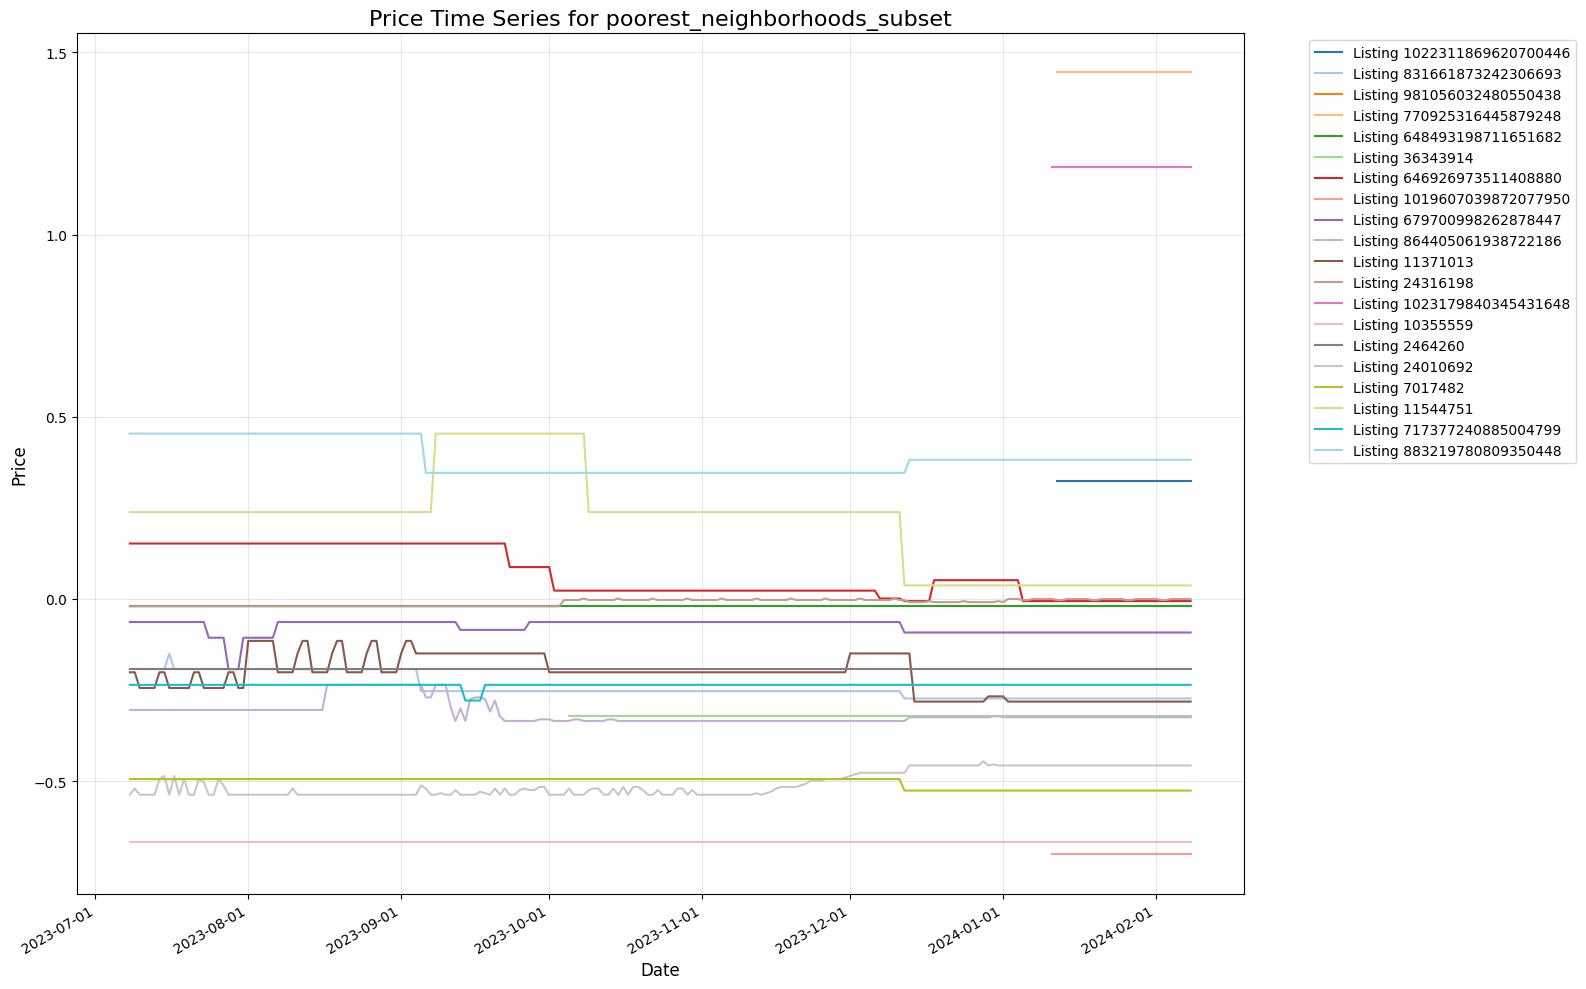

Displayed visualization for poorest_neighborhoods_subset
Loading data for richest_neighborhoods_subset...


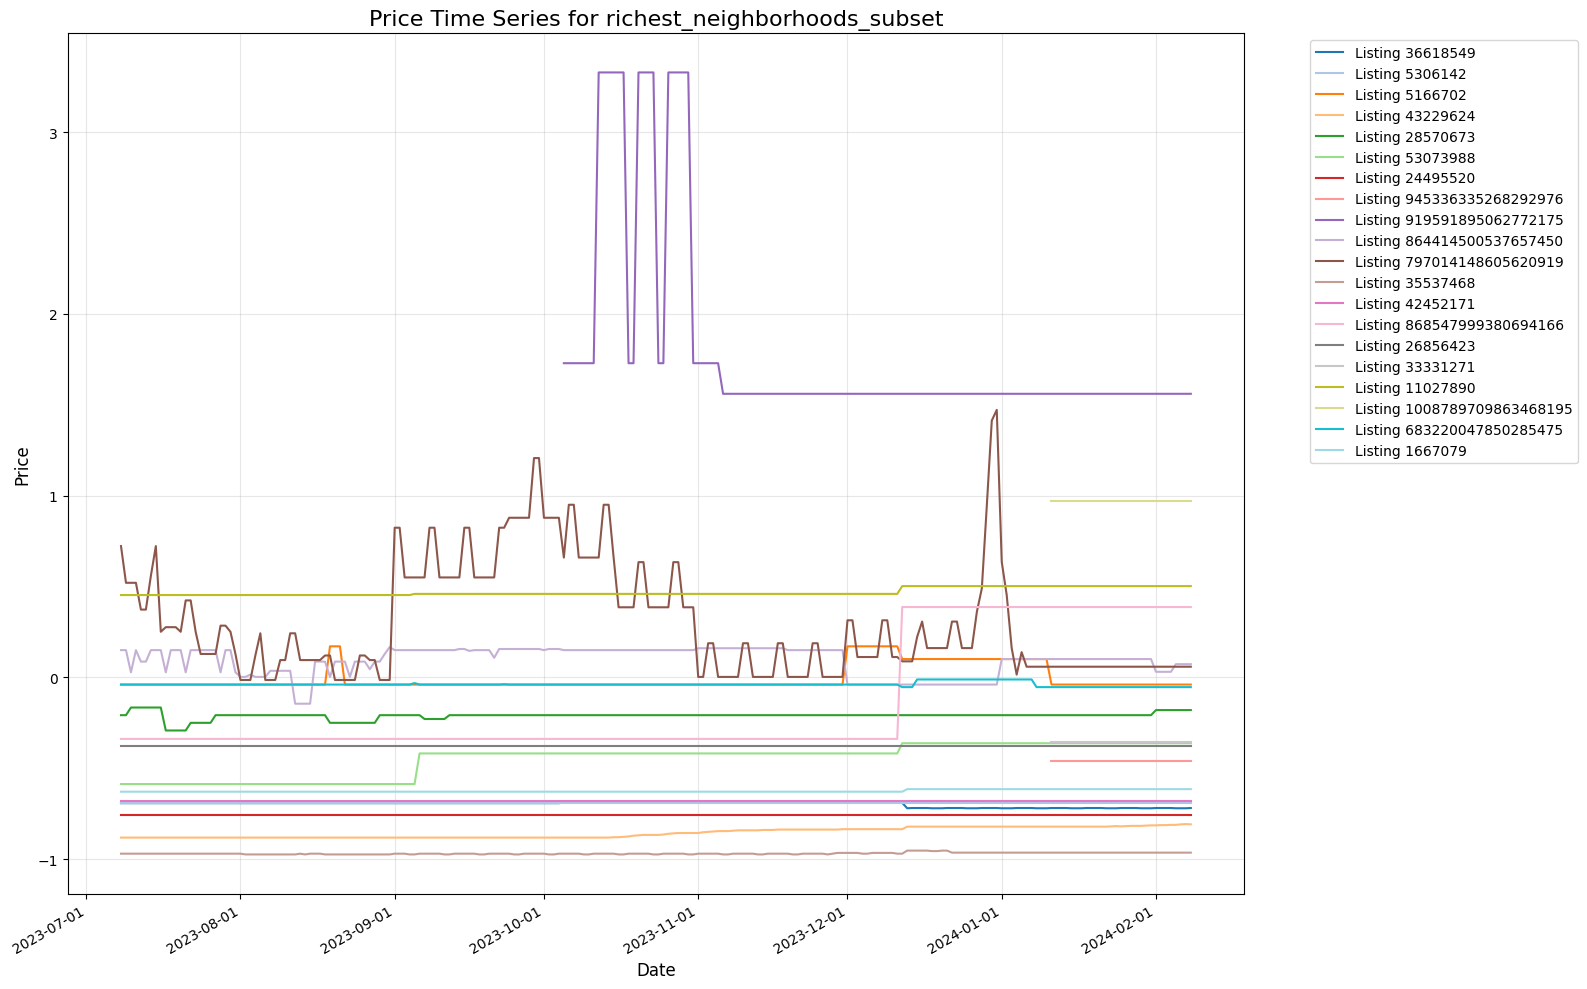

Displayed visualization for richest_neighborhoods_subset
Loading data for temporal_features_combined...


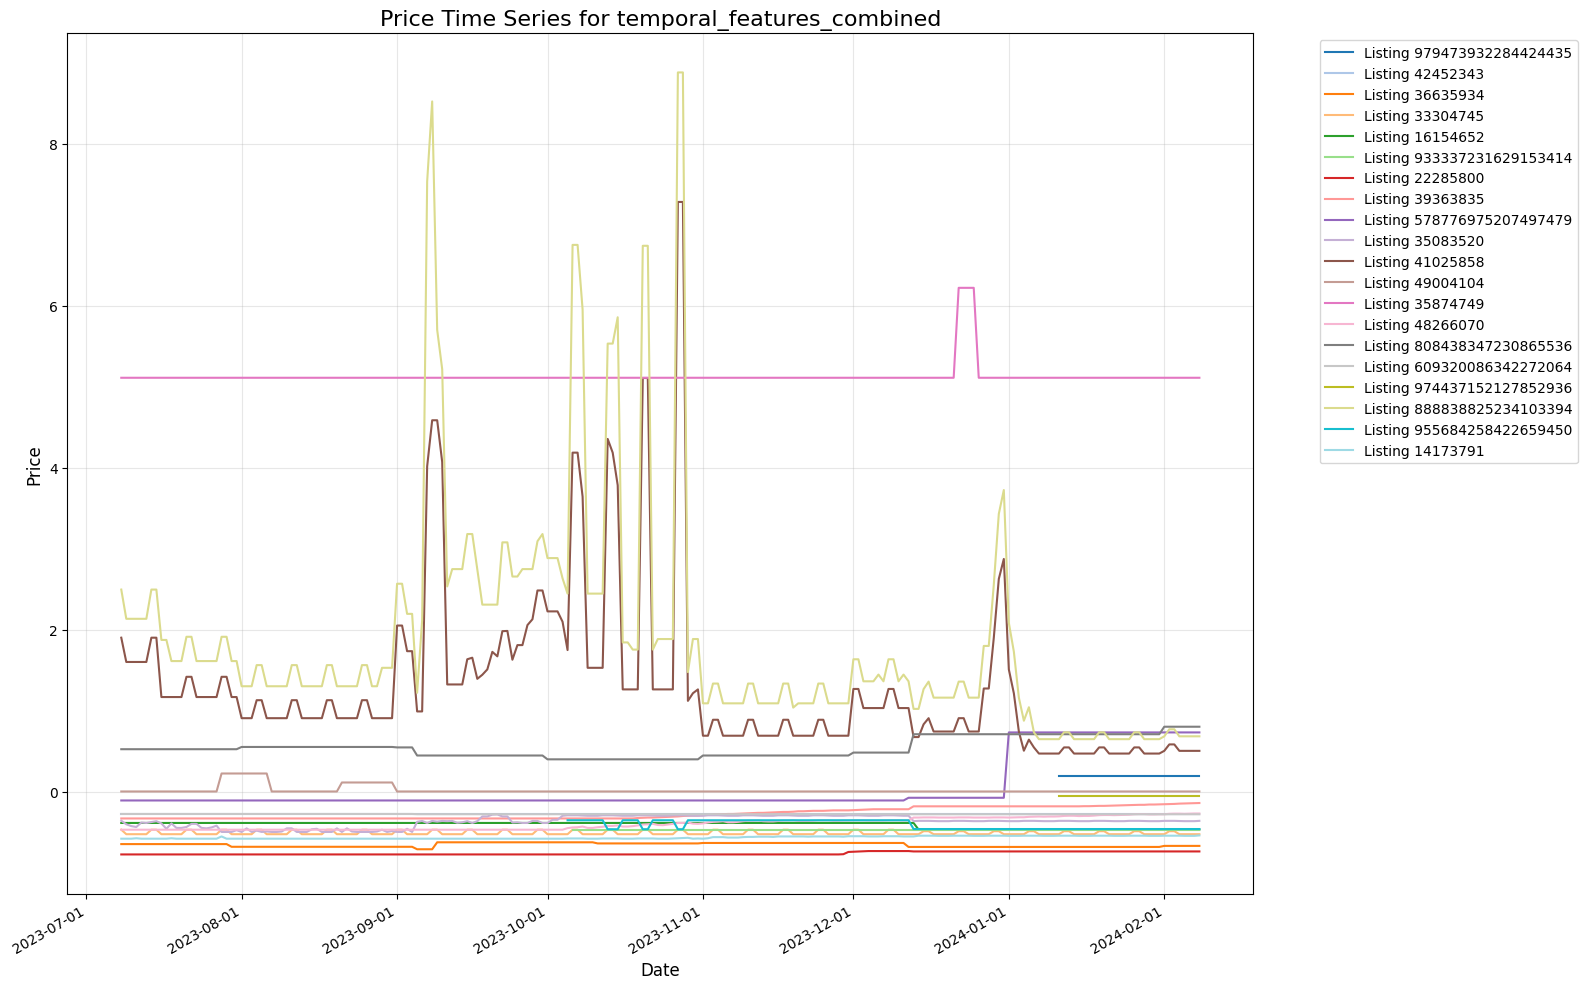

Displayed visualization for temporal_features_combined
Loading data for top_cheapest_listings_subset...


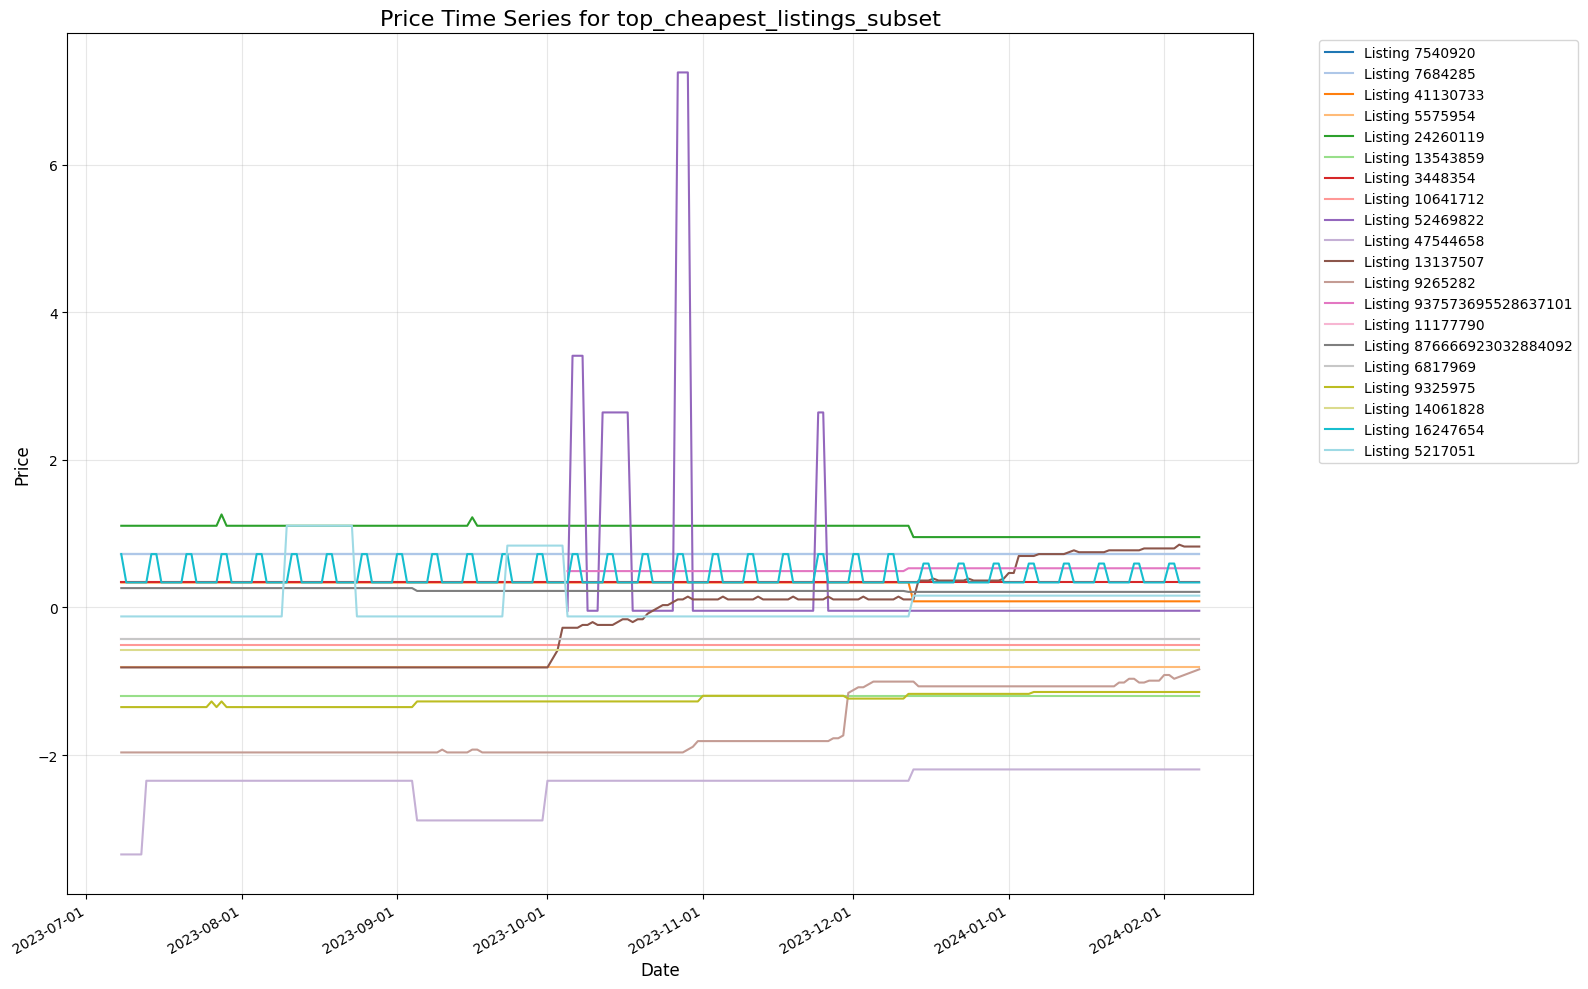

Displayed visualization for top_cheapest_listings_subset
Loading data for top_expensive_listings_subset...


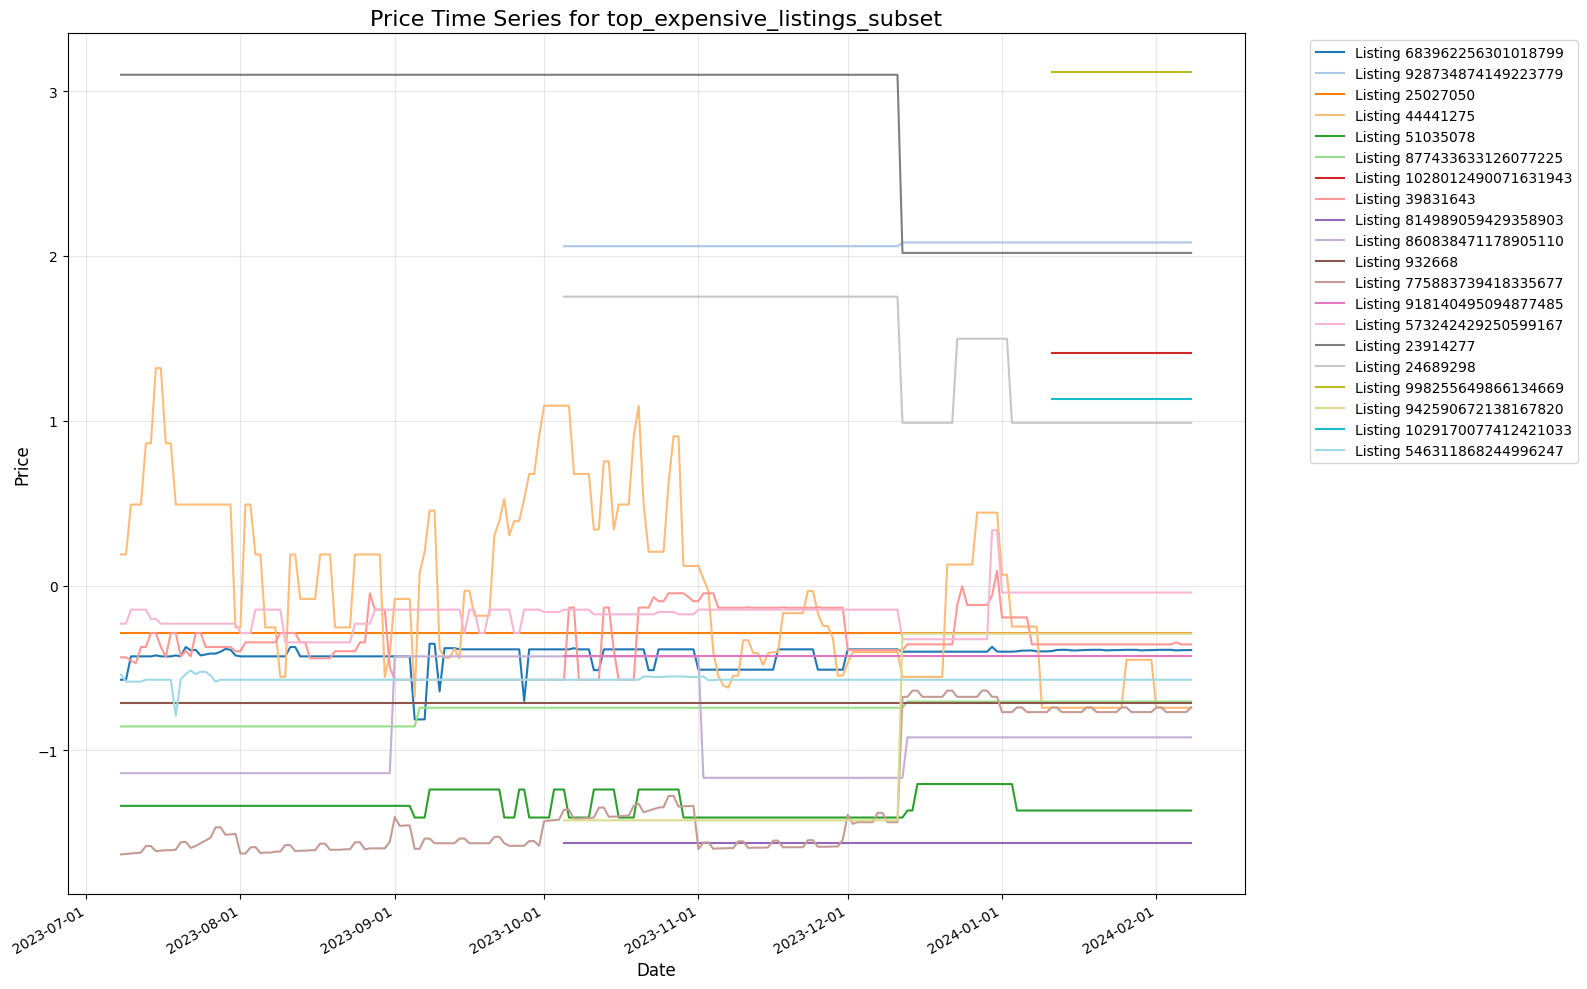

Displayed visualization for top_expensive_listings_subset
Loading data for top_price_changers_subset...


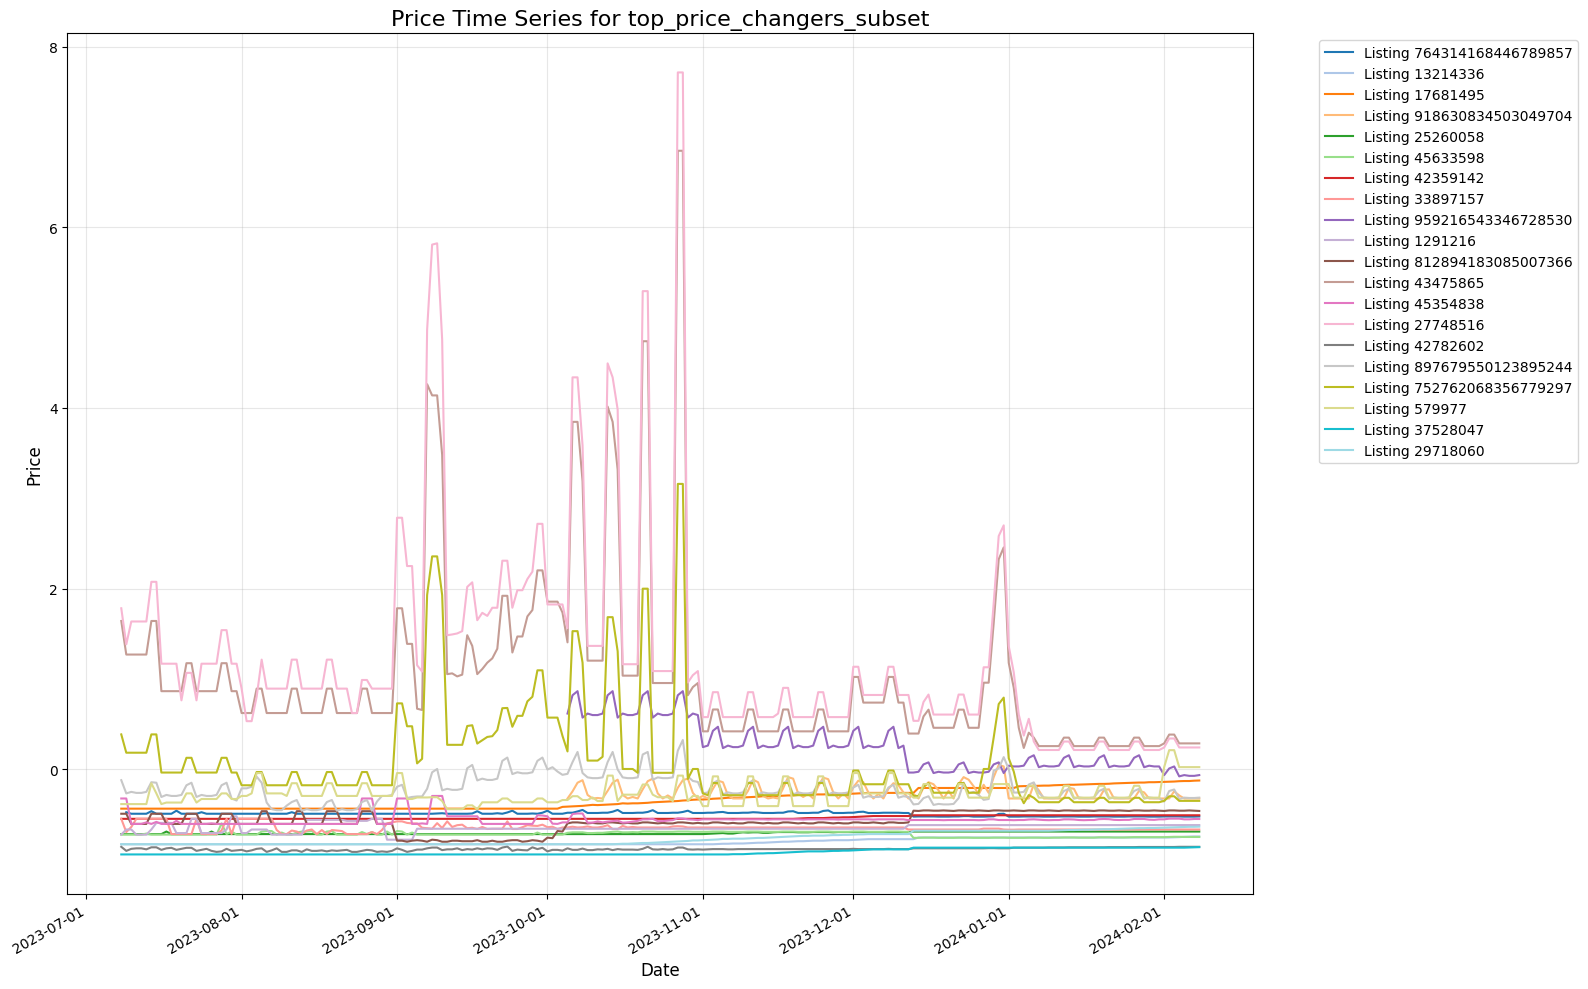

Displayed visualization for top_price_changers_subset
All visualizations completed!


In [2]:
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import datetime
import random
import os

# Define the base directory and subsets
base_dir = r"C:\Users\mvk\Documents\DATA_school\thesis\Subset"
subsets = [
    "poorest_neighborhoods_subset",
    "richest_neighborhoods_subset",
    "temporal_features_combined",
    "top_cheapest_listings_subset",
    "top_expensive_listings_subset",
    "top_price_changers_subset"
]

def plot_subset_data(subset_name):
    # Path to the train data
    train_path = os.path.join(base_dir, subset_name, "train.csv")
    
    # Load the data
    print(f"Loading data for {subset_name}...")
    df = pl.read_csv(train_path)
    
    # Convert date column to datetime
    df = df.with_columns(pl.col("date").str.to_datetime())
    
    # Select 20 random listings
    unique_listings = df["listing_id"].unique().to_list()
    sample_size = min(20, len(unique_listings))
    selected_listings = random.sample(unique_listings, sample_size)
    
    # Create the plot
    plt.figure(figsize=(16, 10))
    colors = plt.cm.tab20.colors  # Get 20 distinct colors
    
    # Plot each listing
    for i, listing_id in enumerate(selected_listings):
        # Filter data for this listing
        listing_data = df.filter(pl.col("listing_id") == listing_id)
        
        # Sort by date
        listing_data = listing_data.sort("date")
        
        # Get dates and prices as numpy arrays for plotting
        dates = listing_data["date"].to_numpy()
        prices = listing_data["price"].to_numpy()
        
        # Plot this listing with its own color
        plt.plot(dates, prices, color=colors[i % len(colors)], linewidth=1.5,
                 label=f"Listing {listing_id}")
    
    # Format the plot
    plt.title(f"Price Time Series for {subset_name}", fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Price", fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Format date axis
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gcf().autofmt_xdate()  # Rotate date labels
    
    # Add legend but place it outside the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    # Display the plot
    plt.show()
    print(f"Displayed visualization for {subset_name}")

# Plot each subset
for subset in subsets:
    try:
        plot_subset_data(subset)
    except Exception as e:
        print(f"Error processing {subset}: {str(e)}")

print("All visualizations completed!")

Loading February test data for poorest_neighborhoods_subset...


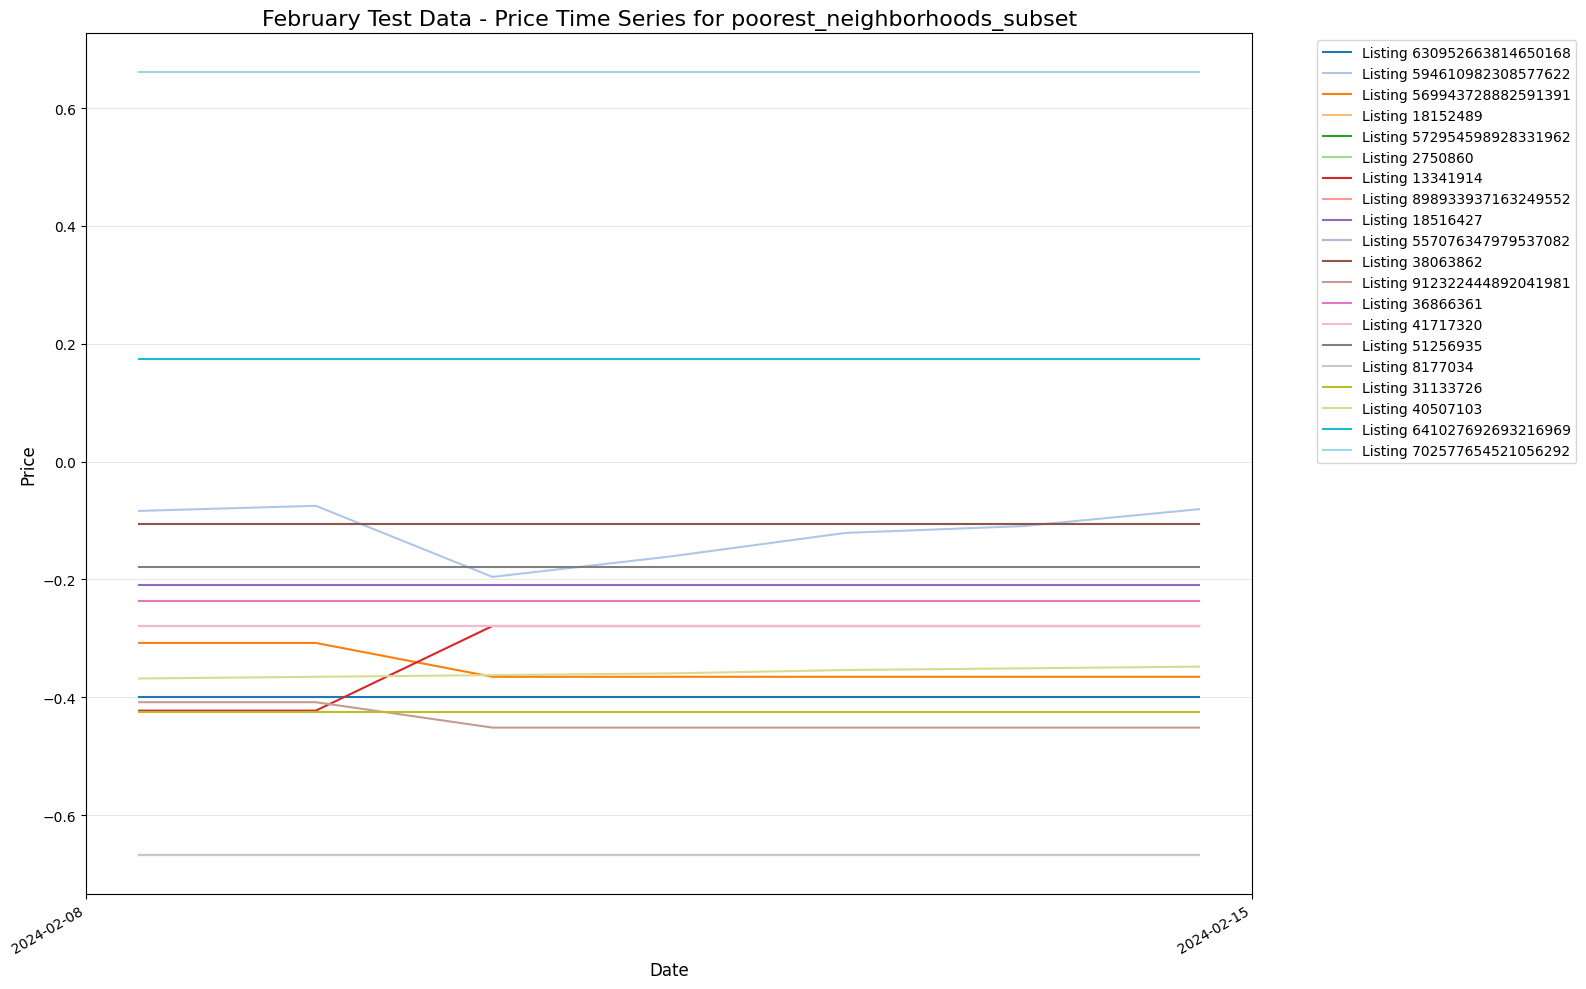

Displayed February test visualization for poorest_neighborhoods_subset
Loading February test data for richest_neighborhoods_subset...


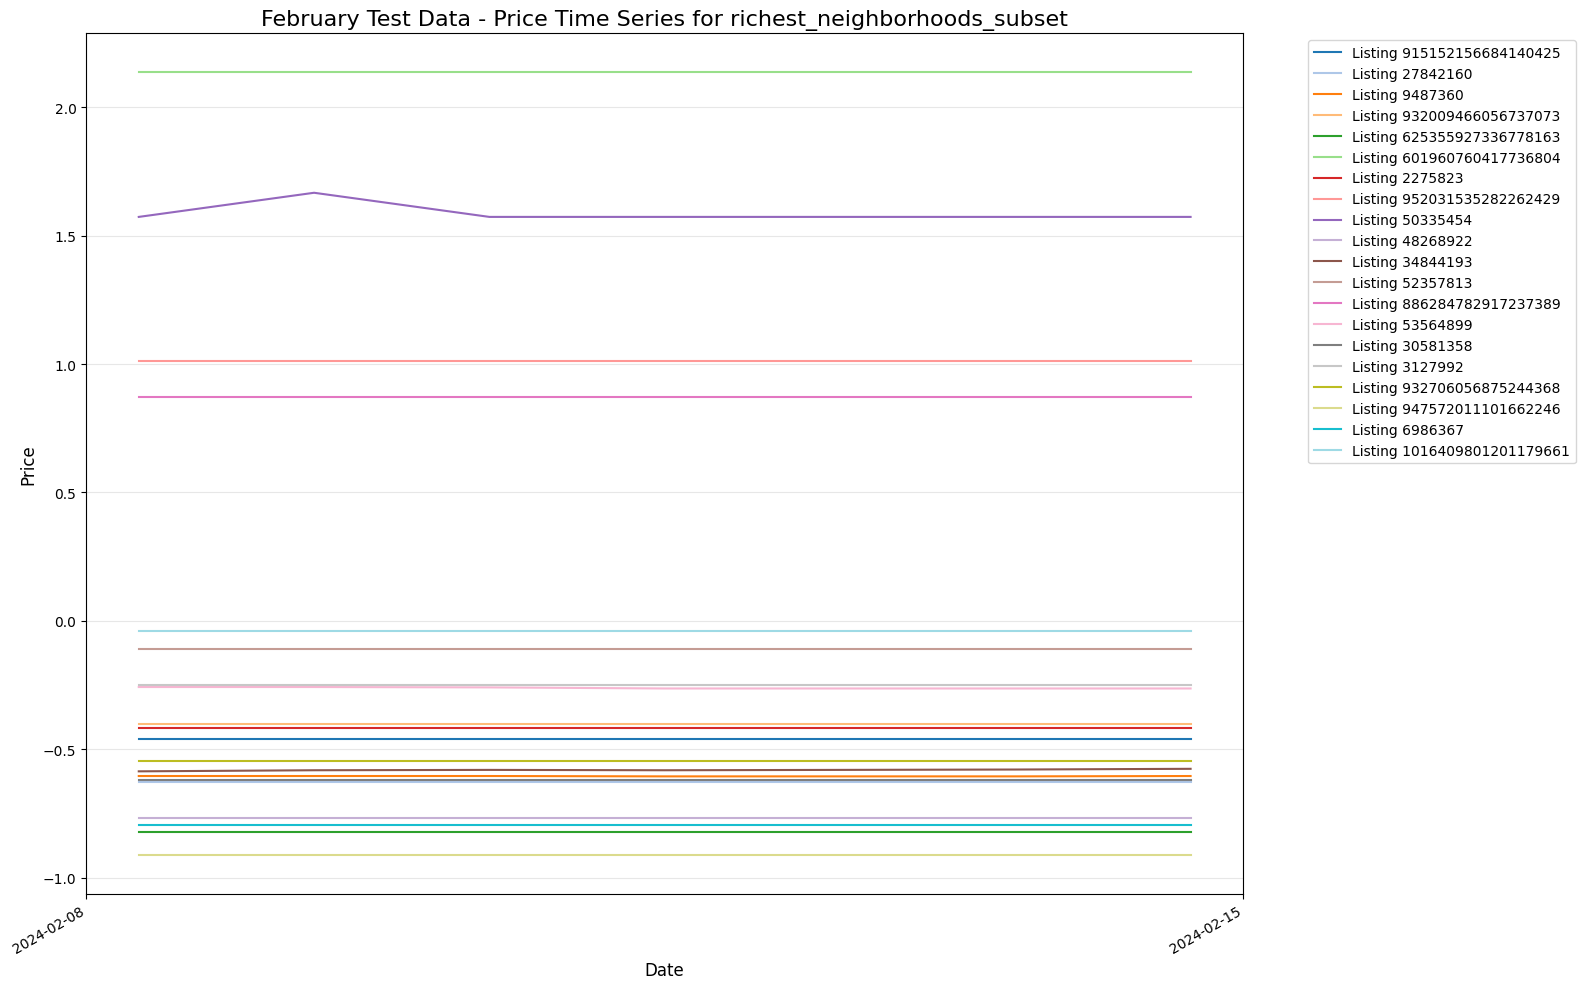

Displayed February test visualization for richest_neighborhoods_subset
Loading February test data for temporal_features_combined...


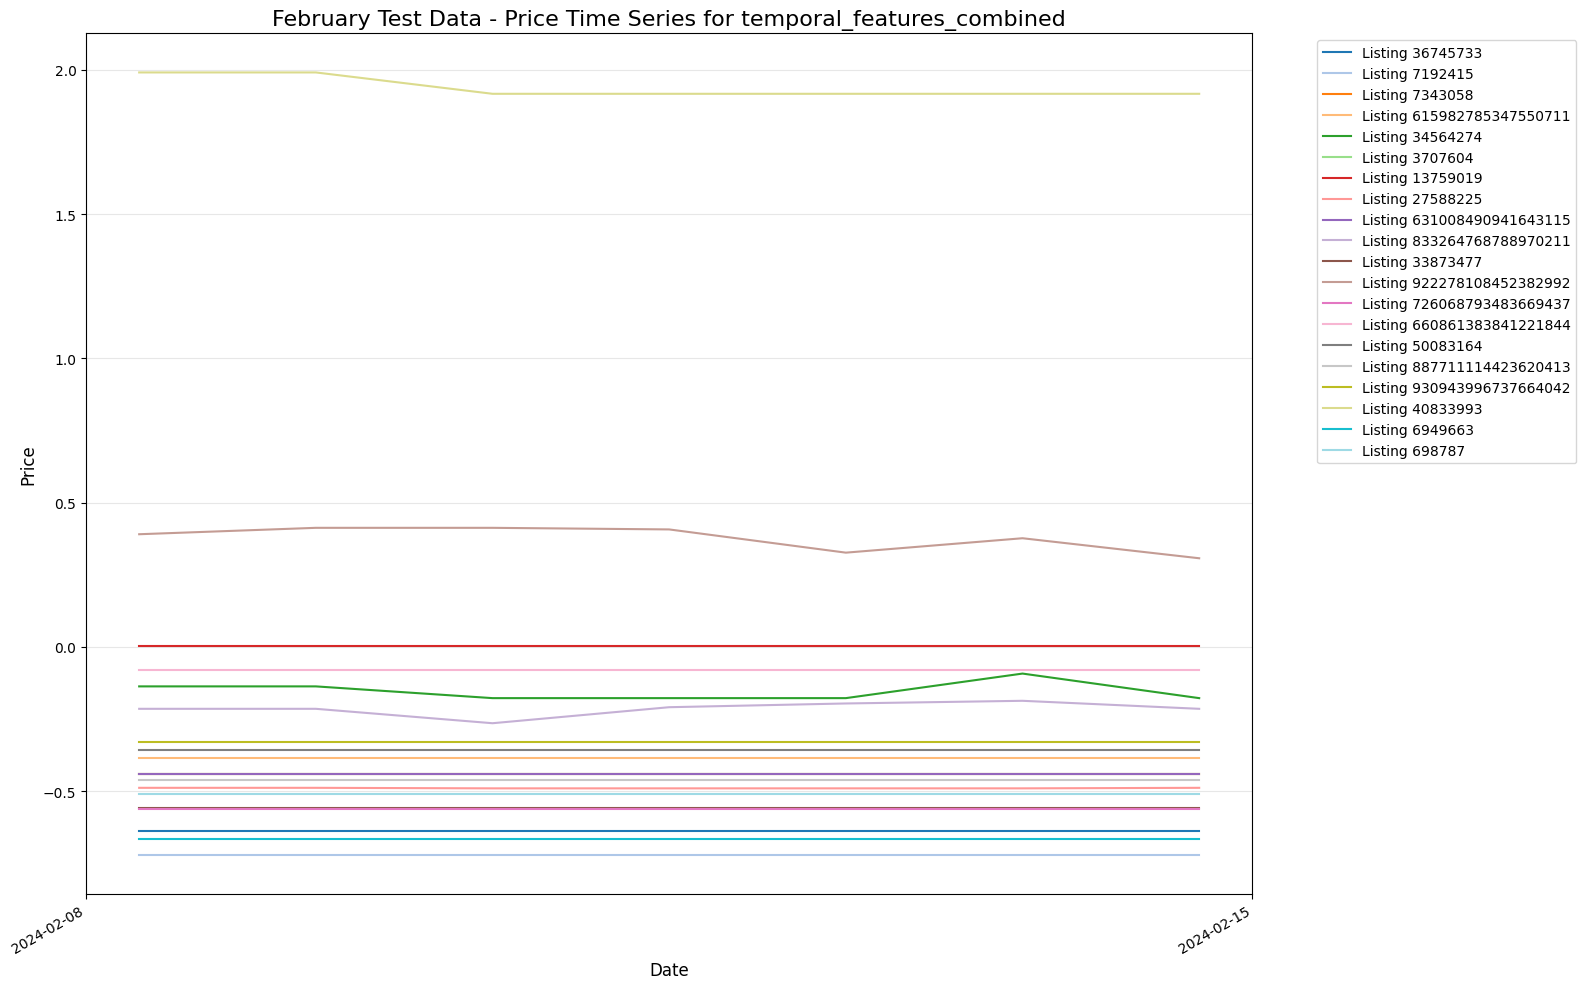

Displayed February test visualization for temporal_features_combined
Loading February test data for top_cheapest_listings_subset...


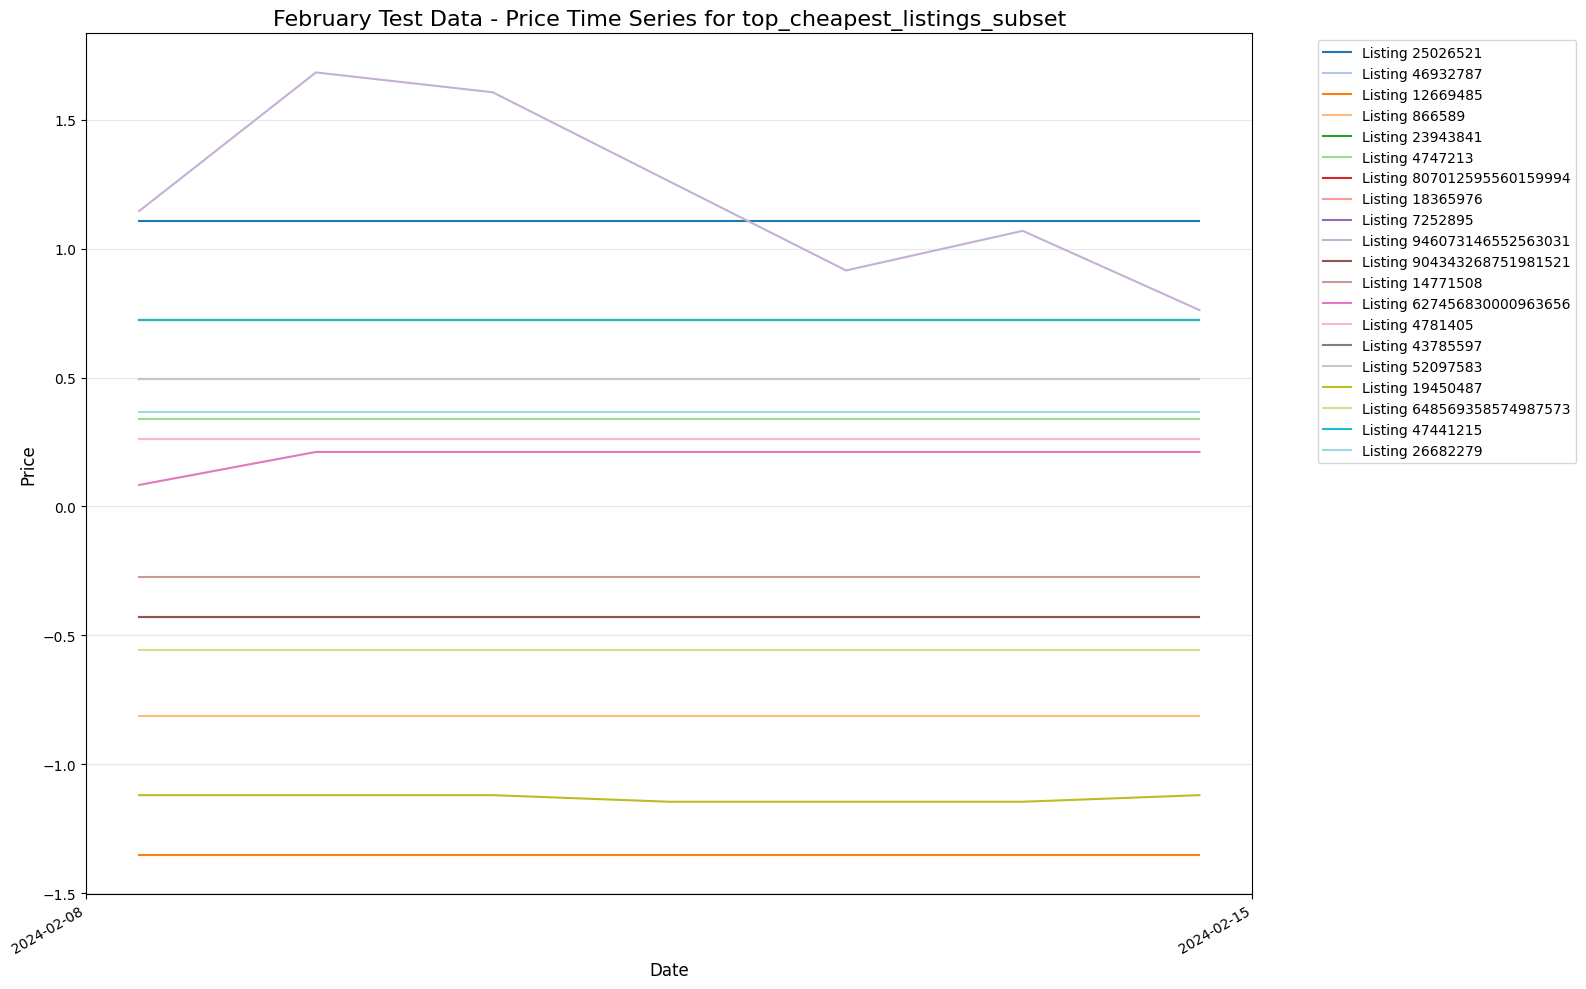

Displayed February test visualization for top_cheapest_listings_subset
Loading February test data for top_expensive_listings_subset...


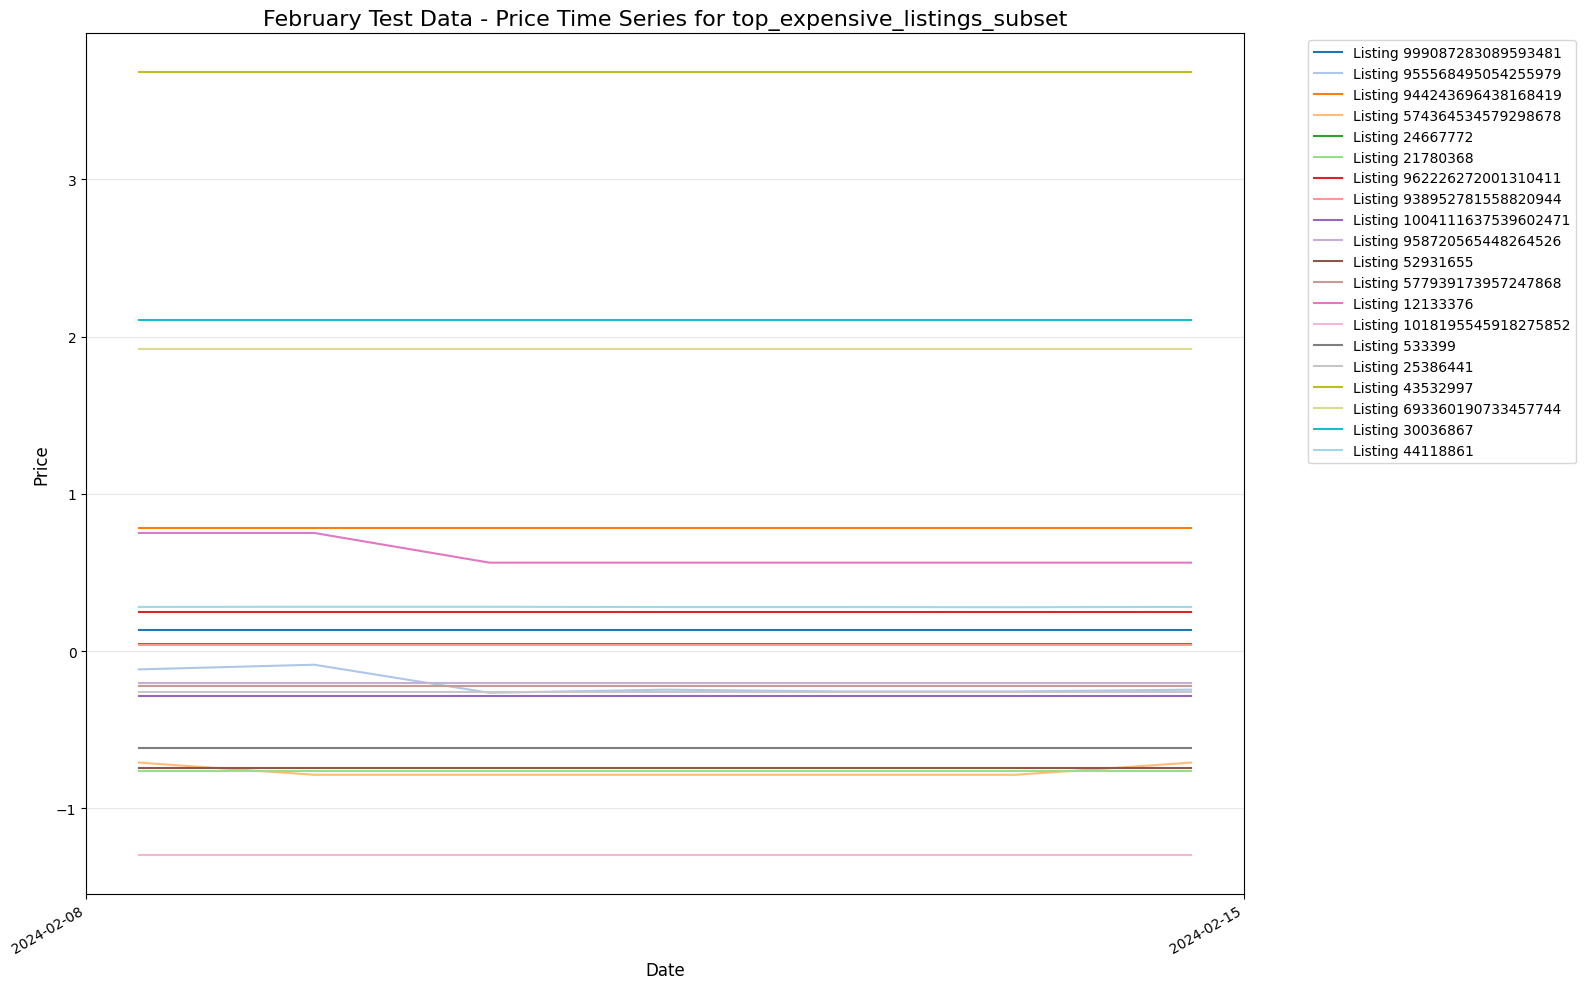

Displayed February test visualization for top_expensive_listings_subset
Loading February test data for top_price_changers_subset...


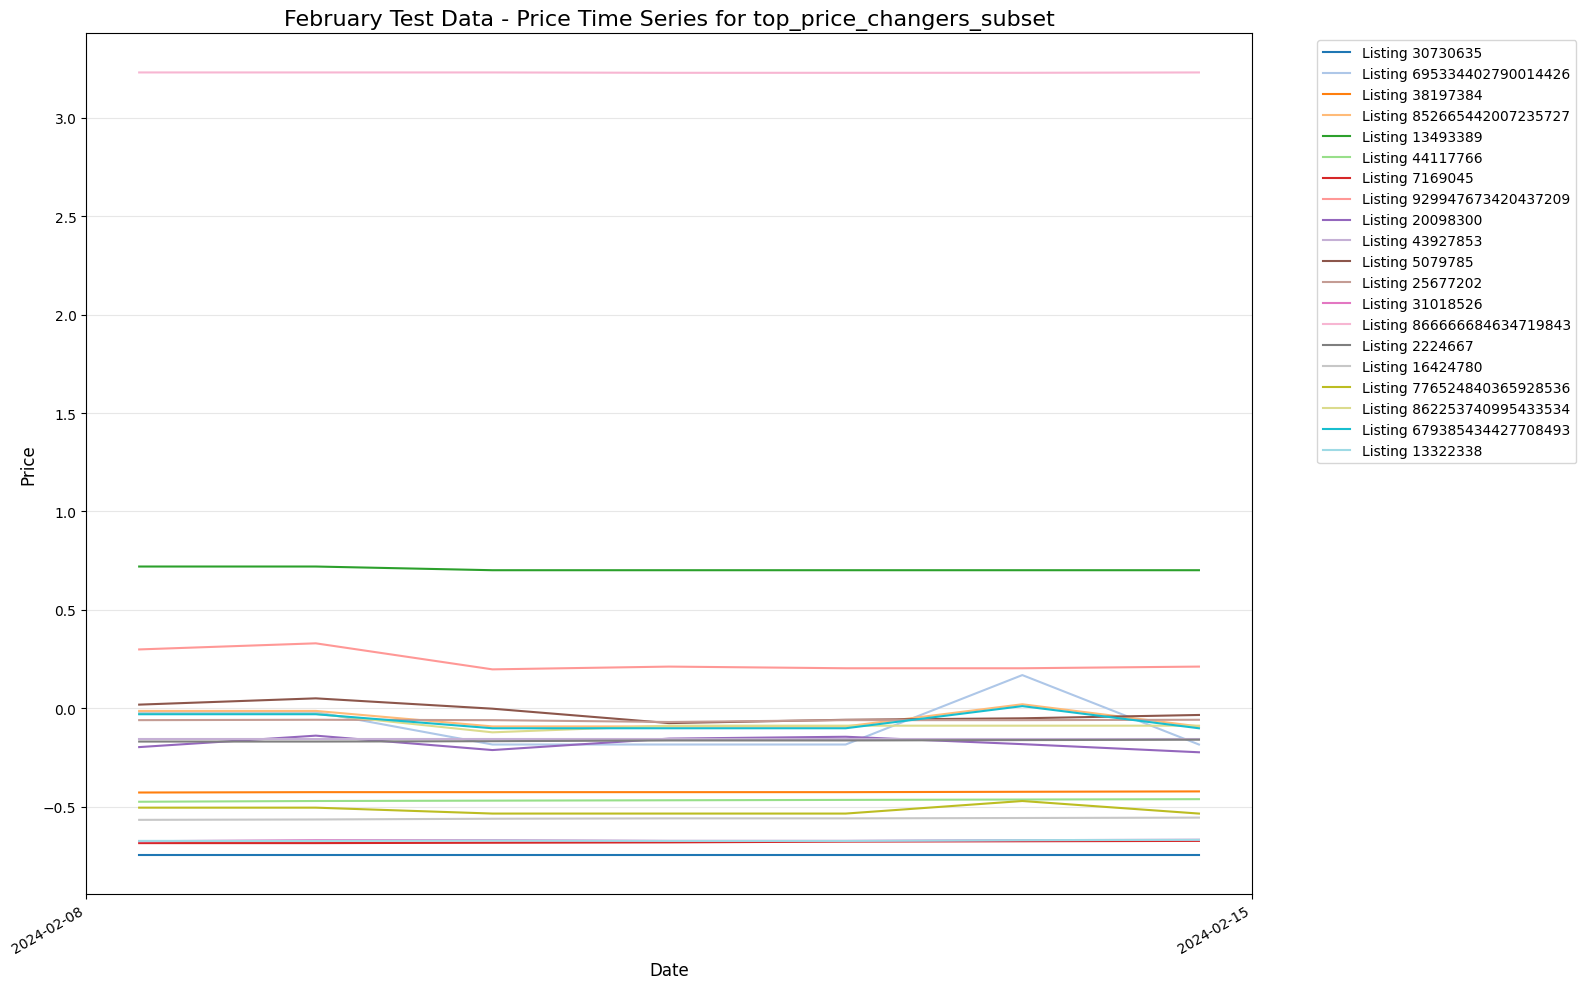

Displayed February test visualization for top_price_changers_subset
All February test visualizations completed!


In [3]:
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import datetime
import random
import os

# Define the base directory and subsets
base_dir = r"C:\Users\mvk\Documents\DATA_school\thesis\Subset"
subsets = [
    "poorest_neighborhoods_subset",
    "richest_neighborhoods_subset",
    "temporal_features_combined",
    "top_cheapest_listings_subset",
    "top_expensive_listings_subset",
    "top_price_changers_subset"
]

def plot_subset_data(subset_name):
    # Path to the test_feb data
    test_path = os.path.join(base_dir, subset_name, "test_feb.csv")
    
    # Load the data
    print(f"Loading February test data for {subset_name}...")
    df = pl.read_csv(test_path)
    
    # Convert date column to datetime
    df = df.with_columns(pl.col("date").str.to_datetime())
    
    # Select 20 random listings
    unique_listings = df["listing_id"].unique().to_list()
    sample_size = min(20, len(unique_listings))
    selected_listings = random.sample(unique_listings, sample_size)
    
    # Create the plot
    plt.figure(figsize=(16, 10))
    colors = plt.cm.tab20.colors  # Get 20 distinct colors
    
    # Plot each listing
    for i, listing_id in enumerate(selected_listings):
        # Filter data for this listing
        listing_data = df.filter(pl.col("listing_id") == listing_id)
        
        # Sort by date
        listing_data = listing_data.sort("date")
        
        # Get dates and prices as numpy arrays for plotting
        dates = listing_data["date"].to_numpy()
        prices = listing_data["price"].to_numpy()
        
        # Plot this listing with its own color
        plt.plot(dates, prices, color=colors[i % len(colors)], linewidth=1.5,
                 label=f"Listing {listing_id}")
    
    # Format the plot
    plt.title(f"February Test Data - Price Time Series for {subset_name}", fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Price", fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Format date axis
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gcf().autofmt_xdate()  # Rotate date labels
    
    # Add legend but place it outside the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    # Display the plot
    plt.show()
    print(f"Displayed February test visualization for {subset_name}")

# Plot each subset
for subset in subsets:
    try:
        plot_subset_data(subset)
    except Exception as e:
        print(f"Error processing {subset}: {str(e)}")

print("All February test visualizations completed!")